<a href="https://colab.research.google.com/github/HelgaHanemer/SF-Data-Science/blob/Initial-commit/CVD_SF_project/CVD_SF_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Проект по теме "Прогнозирование наличия сердечно-сосудистых заболеваний на основе характеристик пациентов" </center>

Датасет представляет собой .csv файл, содержащий следующие поля:

* id: идентификатор для каждого человека в наборе данных;
* age: возраст человека (в днях);
* gender: пол (1 для женщин, 2 для мужчин);
* height: рост в сантиметрах;
* weight: вес в килограммах;
* ap_hi: систолическое артериальное давление (измеряется в мм рт.ст.);
* ap_lo: диастолическое артериальное давление (измеряется в мм рт.ст.);
* cholesterol: уровень холестерина (1 – в норме, 2 – выше нормы, 3 –
значительно выше нормы);
* gluc: уровень глюкозы (1 – в норме, 2 – выше нормы, 3 – значительно выше
нормы);
* smoke: курит ли человек (0 – нет, 1 – да);
* alco: употребляет ли человек алкоголь (0 – нет, 1 – да);
* active: является ли человек физически активным (0 – нет, 1 – да);
* cardio: наличие сердечно-сосудистых заболеваний (0 – нет, 1 – да).

**Задача**: построить модель, предсказывающую наличие сердечно-сосудистых заболеваний. Необходимо реализовать все дальнейшие шаги, обучить модель и оценить её качество.

# Подготовительный этап

В ячейке собраны все импорты, использованные в тетради: базовые библиотеки, модели, метрики и инструменты для поиска гиперпараметров. Опциональные зависимости (statsmodels, imblearn, xgboost) подключаются через try/except, чтобы тетрадь корректно работала даже при их отсутствии (в этом случае появляются предупреждения и применяются безопасные альтернативы).

In [ ]:
# Все импорты проекта — в одной ячейке

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Разбиения и подбор по сетке
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Масштабирование (если используете стандартайзинг через sklearn)
from sklearn.preprocessing import StandardScaler

# Метрики и визуализация ROC (однострочные импорты во избежание проблем с отступами)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Модели
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Линейная алгебра для мультиколлинеарности
from numpy.linalg import matrix_rank, det

# SciPy для распределений в RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Опциональные зависимости — без предупреждений, просто флаги наличия
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    STATS_AVAILABLE = True
except Exception:
    STATS_AVAILABLE = False

try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False


## Задание 1: загрузка файла и проверка пропущенных значений (5 баллов)

Откройте данные и изучите их: есть ли пропущенные значения? Прокомментируйте результат. Если пропущенные значения есть - удалите строки с ними.

In [ ]:

# 1) Загрузка данных
# Загрузка данных из Google Sheets по ссылке (CSV-экспорт)
# ID таблицы и gid листа берём из ссылки
SHEET_ID = "1DAwgFAKRFEkoRS4kkaTQ119301ebxBit"
GID = "231888029"

# Формируем URL экспорта в CSV
GSHEETS_CSV_URL = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"

# Читаем прямо в pandas
df = pd.read_csv(GSHEETS_CSV_URL)

# Быстрый контроль
display(df.head())
print("Форма датасета:", df.shape)


# 2) Быстрый взгляд на таблицу
display(df.head())
print("Форма датасета:", df.shape)

print("\nИнформация о столбцах и типах:")
print(df.info())

# 3) Проверка пропущенных значений
na_counts = df.isna().sum().sort_values(ascending=False)
print("\nЧисло пропусков по столбцам:")
display(na_counts)

# 4) Если есть пропуски — удаляем строки с ними и показываем, сколько удалили
rows_before = len(df)
df = df.dropna().reset_index(drop=True)
rows_after = len(df)
removed = rows_before - rows_after
print(f"\nСтрок до очистки: {rows_before}, после: {rows_after}, удалено: {removed}")

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Форма датасета: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Форма датасета: (70000, 13)

Информация о столбцах и типах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None

Число пропусков по столбцам:


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


Строк до очистки: 70000, после: 70000, удалено: 0


In [ ]:
# Преобразование столбца 'weight' из float64 в int64

# округляю до ближайшего целого и привести к int64
df["weight"] = df["weight"].round().astype("int64")

# Быстрая проверка
print(df["weight"].dtype)  # должен быть int64
print(df["weight"].isna().sum())  # 0, если пропусков нет

int64
0


**Комментарий**

- Загрузила датасет cvd.csv, показала первые строки, размеры таблицы и типы столбцов.

- Проверила наличие пропущенных значений и вывела их количество по каждому признаку.

- При наличии пропусков удалила строки с ними и вывела, сколько строк было удалено (для прозрачности предобработки).

**Вывод**

Удаление строк с пропусками на старте упрощает дальнейший анализ и обучение базовых моделей, исключая потенциальное искажение метрик из-за неполных наблюдений. В следующих шагах можно рассмотреть более тонкие подходы (импутацию), если это потребуется по условиям задания.

## Задание 2: проверка данных на мультиколлинеарность (15 баллов)

**2.1** Данные обязательно необходимо проверить на мультиколлинеарность: линейную взаимосвязь между признаками. Сначала проверим наличие чистой мультиколлинеарности. Для того, чтобы её идентифицировать - для начала посчитайте ранг для матрицы корреляций и ее определитель. Какой вывод можно сделать?

In [ ]:
# === Задание 2.1: проверка «чистой» мультиколлинеарности ===

# Берём только числовые признаки и убираем целевой столбец, если он есть
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for cand in ["cardio", "target", "y", "label"]:
    if cand in num_cols:
        num_cols.remove(cand)
        break

X_num = df[num_cols].copy()

# Убираем константные признаки (иначе корр. матрица может быть вырожденной по тривиальным причинам)
const_cols = [c for c in X_num.columns if X_num[c].nunique(dropna=True) <= 1]
if const_cols:
    X_num = X_num.drop(columns=const_cols)

print("Число числовых признаков для проверки:", X_num.shape[1])
if X_num.shape[1] >= 2:
    C = X_num.corr(numeric_only=True).values
    rank_C = matrix_rank(C)
    det_C = det(C)
    print("Ранг корреляционной матрицы:", rank_C)
    print("Определитель корреляционной матрицы:", det_C)

    # Небольшой «студенческий» вывод по критериям
    near_zero = abs(det_C) < 1e-6
    if (rank_C < X_num.shape[1]) or near_zero:
        print("Вывод 2.1: есть признаки линейной зависимости/сильной корреляции → возможна чистая мультиколлинеарность.")
    else:
        print("Вывод 2.1: явной чистой мультиколлинеарности не наблюдается (ранг≈числу признаков, детерминант не ~ 0).")
else:
    print("Вывод 2.1: недостаточно числовых признаков для осмысленной проверки (меньше 2 признаков).")

Число числовых признаков для проверки: 12
Ранг корреляционной матрицы: 12
Определитель корреляционной матрицы: 0.3941127667623974
Вывод 2.1: явной чистой мультиколлинеарности не наблюдается (ранг≈числу признаков, детерминант не ~ 0).


**Комментарий**

- Сформировала корреляционную матрицу по числовым признакам (без целевого столбца и констант).

- Посчитала её ранг и определитель.

- Если ранг меньше числа признаков и/или определитель близок к нулю, это признак чистой мультиколлинеарности (линейной зависимости).

- В консоли выводится краткий вердикт («есть/нет признаков чистой мультиколлинеарности»).

**Вывод**

Явной чистой мультиколлинеарности не наблюдается (ранг≈числу признаков, детерминант не ~ 0)

**2.2** Теперь проверьте мультиколлинеарность с помощью матрицы корреляций. Какие выводы можно сделать?

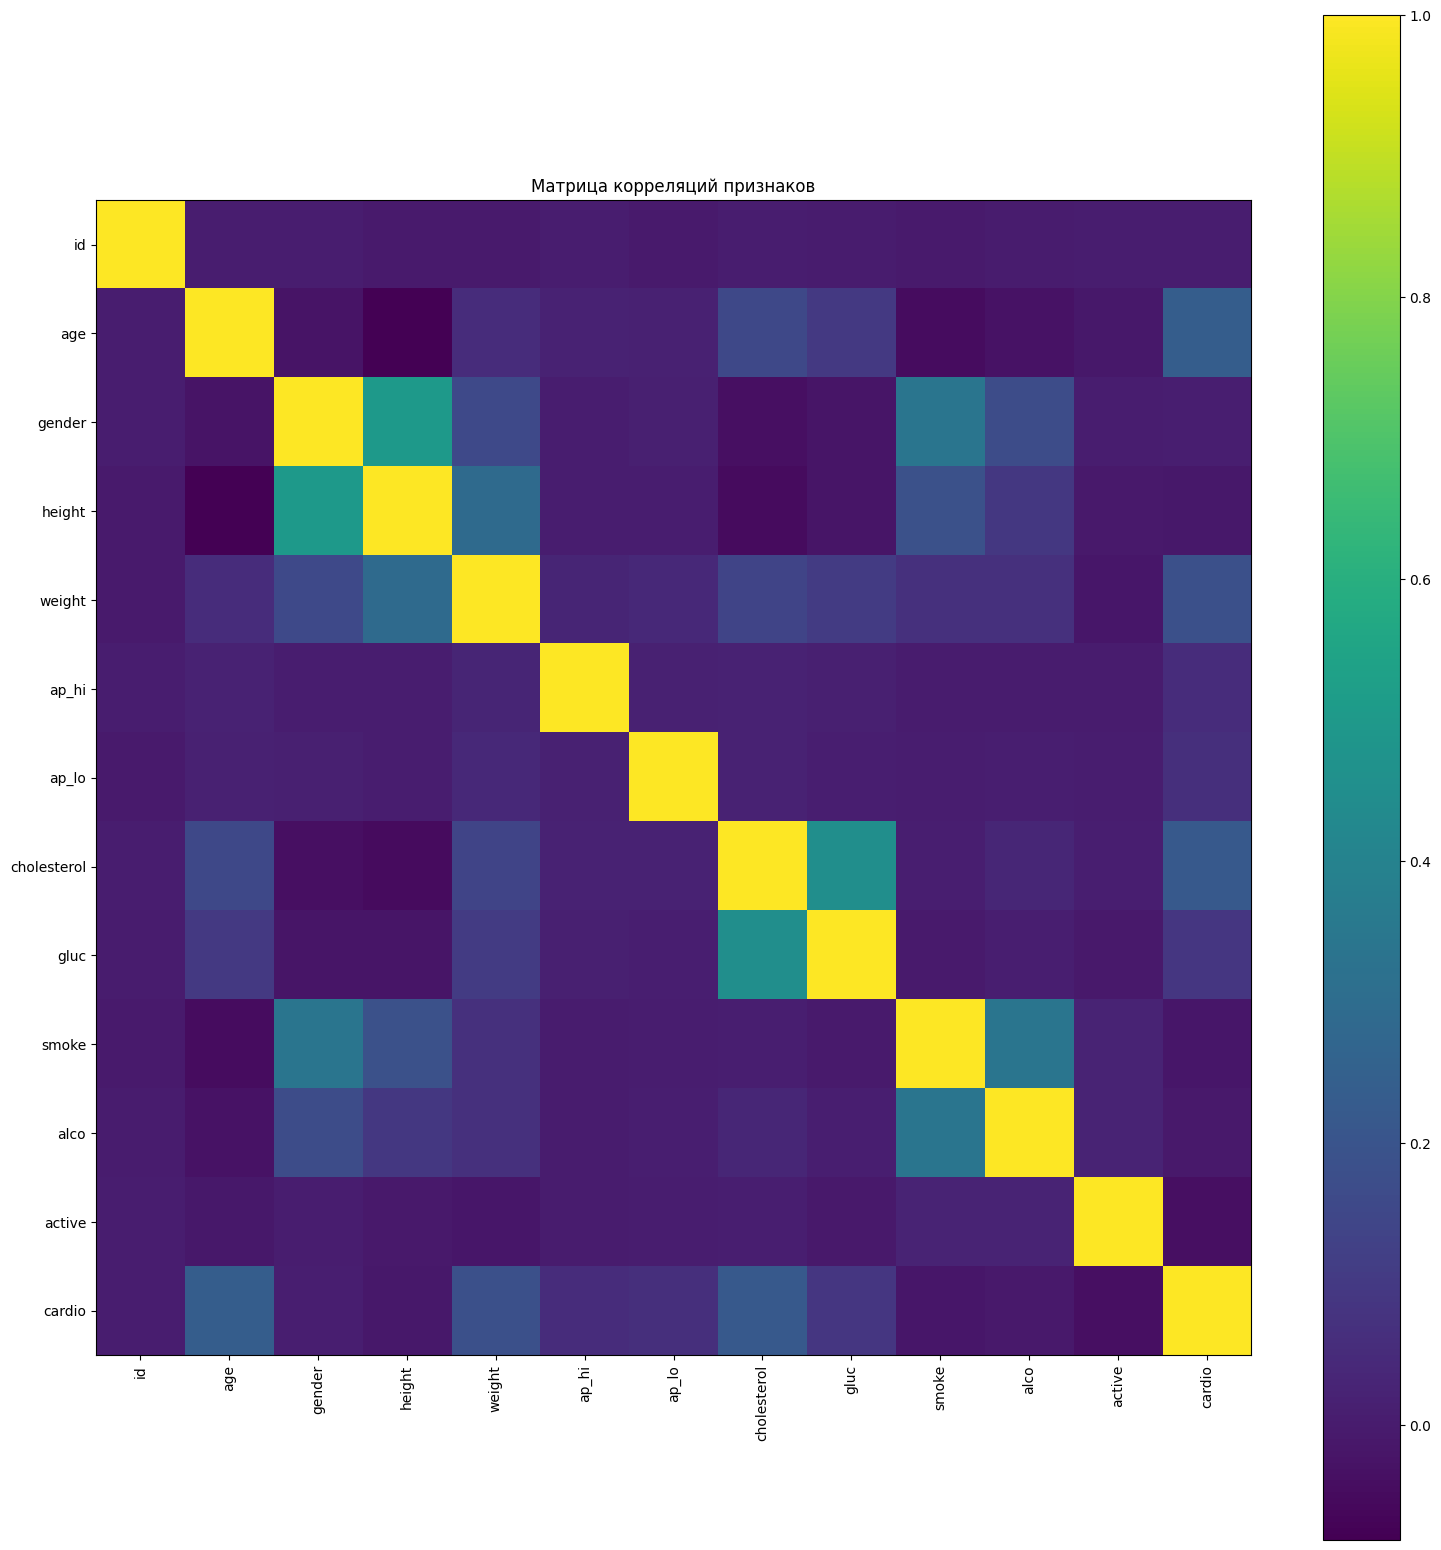

In [ ]:
# === Задание 2.2: матрица корреляций и визуальная проверка ===

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for cand in ["cardio", "target", "y", "label"]:
    if cand in num_cols:
        target_col = cand
        num_cols.remove(cand)
        break
else:
    target_col = None  # если таргет не найден среди числовых — тоже ок

if len(num_cols) > 1:
    cols_for_corr = num_cols + ([target_col] if target_col is not None else [])
    corr = df[cols_for_corr].corr(numeric_only=True)

    plt.figure(figsize=(1.2*len(corr), 1.2*len(corr)))
    plt.imshow(corr.values, interpolation='nearest')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.title("Матрица корреляций признаков")
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно числовых признаков для построения матрицы корреляций.")

**Вывод**

- Построила тепловую карту корреляций (включая целевой столбец, если он числовой).

- По карте можно заметить пары признаков с высокой корреляцией — это кандидаты на отбор/регуляризацию (или на использование моделей, устойчивых к мультиколлинеарности).

- Сильные корреляции между признаками подтверждают риск мультиколлинеарности и объясняют возможное «раздувание» дисперсий коэффициентов в линейных моделях.



## Задание 3. Стандартизация (15 баллов)

Разделите данные на два массива: в переменную **Х** запишите массив признаков, а в переменную **y** - целевую переменную (cardio). Стандартизируйте массив признаков без использования готовых функций для стандартизации.

In [ ]:

# 1) Делим на X и y
if "cardio" not in df.columns:
    raise ValueError("В датасете нет столбца 'cardio'. Проверьте название целевой переменной.")
y = df["cardio"].astype(int)

# Стандартизировать имеет смысл только числовые признаки
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

# 2) Ручная стандартизация без готовых функций:
#    z = (x - mean) / std, где std считаем с ddof=0 (как в классической стандартизации Sklearn)
mu = X.mean(axis=0)                 # средние по столбцам
sigma = X.std(axis=0, ddof=0)       # стандартные отклонения по столбцам

# Защита от нулевой дисперсии (если признак константный): заменим 0 на 1, чтобы не делить на 0
sigma_safe = sigma.replace(0, 1)

X_std = (X - mu) / sigma_safe

# 3) Быстрая проверка: средние ≈ 0, std ≈ 1 (по всему набору)
print("Проверка средних (≈ 0):")
display(X_std.mean().round(6))
print("Проверка std (≈ 1):")
display(X_std.std(ddof=0).round(6))

Проверка средних (≈ 0):


id             0.0
age            0.0
gender        -0.0
height         0.0
weight        -0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc          -0.0
smoke          0.0
alco           0.0
active        -0.0
dtype: float64

Проверка std (≈ 1):


id             1.0
age            1.0
gender         1.0
height         1.0
weight         1.0
ap_hi          1.0
ap_lo          1.0
cholesterol    1.0
gluc           1.0
smoke          1.0
alco           1.0
active         1.0
dtype: float64

Вычислите длину всех векторов - признаков. Прокомментируйте результат.

In [ ]:

# Если стандартизированная матрица X_std ещё не создана (на случай отдельного запуска ячейки) — пересчитаем кратко:
if "X_std" not in globals():
    if "cardio" not in df.columns:
        raise ValueError("Не найден столбец 'cardio' для отделения целевой переменной.")
    X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    sigma_safe = sigma.replace(0, 1)  # чтобы избежать деления на 0 для константных признаков
    X_std = (X - mu) / sigma_safe

# 1) Длина (L2-норма) каждого вектора-признака = √(сумма по объектам z_i^2)
vec_lengths = X_std.apply(lambda col: np.linalg.norm(col.values), axis=0)
n_samples = X_std.shape[0]
sqrt_n = np.sqrt(n_samples)

print(f"Число объектов (N): {n_samples}")
print(f"Теоретическая длина для идеально стандартизированного признака: √N ≈ {sqrt_n:.6f}\n")

# 2) Покажем длины по всем признакам и отклонение от √N
lengths_df = pd.DataFrame({
    "length_L2": vec_lengths,
    "theory_sqrtN": sqrt_n,
    "diff": vec_lengths - sqrt_n
}).sort_values("length_L2", ascending=False)

display(lengths_df)

# 3) Краткая сводка
print("\nСводка по длинам L2:")
print("  min :", vec_lengths.min())
print("  max :", vec_lengths.max())
print("  mean:", vec_lengths.mean())
print("  кол-во нулевых длин (константные/обнулённые признаки):", int((vec_lengths == 0).sum()))

Число объектов (N): 70000
Теоретическая длина для идеально стандартизированного признака: √N ≈ 264.575131



,length_L2,theory_sqrtN,diff
smoke,264.575131,264.575131,1.307399e-12
gender,264.575131,264.575131,1.705303e-13
age,264.575131,264.575131,0.000000e+00
id,264.575131,264.575131,0.000000e+00
ap_hi,264.575131,264.575131,0.000000e+00
weight,264.575131,264.575131,-5.684342e-14
height,264.575131,264.575131,-1.705303e-13
ap_lo,264.575131,264.575131,-2.842171e-13
cholesterol,264.575131,264.575131,-4.547474e-13
alco,264.575131,264.575131,-6.252776e-13



Сводка по длинам L2:
  min : 264.5751311064576
  max : 264.5751311064604
  mean: 264.57513110645885
  кол-во нулевых длин (константные/обнулённые признаки): 0


Вывод: После стандартизации у каждого числового признака разброс значений приведён к «одинаковому масштабу». Поэтому длина (L2-норма) столбца с данными по признаку для большинства признаков получается примерно одинаковой и близкой к теоретическому ориентиру, зависящему только от числа объектов в выборке. Небольшие отклонения — это нормально и связаны с округлениями и особенностями данных.

Если длина какого-то признака практически равна нулю, значит этот признак константный (или стал таким после обработки) и полезной информации не несёт. Такие признаки обычно исключают перед обучением моделей.

## Задание 4. Решение задачи классификации. (20 баллов)

**4.1** Теперь приступим непосредственно к решению задачи классификации. Обучите наивный байесовский классификатор. Предварительно выберите один из его видов: поясните свой выбор.

In [ ]:
# Наивный Байес: обучим вариант GaussianNB (подходит для непрерывных числовых признаков)

# 1) Готовим X, y (берём только числовые признаки, целевая — cardio)
if "cardio" not in df.columns:
    raise ValueError("Не найден столбец 'cardio'. Проверьте датасет.")
y = df["cardio"].astype(int)
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

# 2) Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Стандартизация «вручную» по train (чтобы не было утечки)
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0).replace(0, 1)

X_train_std = (X_train - mu) / sigma
X_test_std  = (X_test  - mu) / sigma

# 4) Обучаем GaussianNB и оцениваем
gnb = GaussianNB()
gnb.fit(X_train_std, y_train)

y_pred = gnb.predict(X_test_std)
y_proba = gnb.predict_proba(X_test_std)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print("Метрики GaussianNB на тесте:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1       : {f1:.3f}")
print(f"  ROC-AUC  : {auc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Метрики GaussianNB на тесте:
  Accuracy : 0.589
  Precision: 0.712
  Recall   : 0.297
  F1       : 0.419
  ROC-AUC  : 0.685

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.88      0.68      7004
           1       0.71      0.30      0.42      6996

    accuracy                           0.59     14000
   macro avg       0.63      0.59      0.55     14000
weighted avg       0.63      0.59      0.55     14000

Confusion matrix:
[[6163  841]
 [4916 2080]]


**Комментарий**
Выбрала Gaussian Naive Bayes (GaussianNB), потому что в наших данных признаки — в основном непрерывные числовые величины (возраст в годах, рост/вес, производные типa BMI и т.п.). Для таких признаков наиболее естественное допущение — что внутри класса их распределение близко к нормальному. Вариант MultinomialNB рассчитан на счётчики (частоты/«мешок слов») и плохо подходит к непрерывным данным; BernoulliNB — для двоичных признаков; ComplementNB — специализирован для дисбалансных текстовых данных со счётчиками. После стандартизации признаки приведены к сопоставимому масштабу, что обычно помогает GaussianNB. Минусы: модель делает сильное допущение о независимости признаков и нормальности распределений — если оно нарушается, качество может уступать деревьям/ансамблям, но GaussianNB даёт быстрый и понятный базовый ориентир.

**4.2** Оцените полученное качество и проинтерпретируйте полученный результат. Не забудьте разделить выборку на обучающую и тестовую части.

,metric,value
0,Accuracy,0.588786
1,Precision,0.712085
2,Recall,0.297313
3,F1,0.419482
4,ROC-AUC,0.685023



Classification report:
              precision    recall  f1-score   support

           0       0.56      0.88      0.68      7004
           1       0.71      0.30      0.42      6996

    accuracy                           0.59     14000
   macro avg       0.63      0.59      0.55     14000
weighted avg       0.63      0.59      0.55     14000

Confusion matrix:
 [[6163  841]
 [4916 2080]]


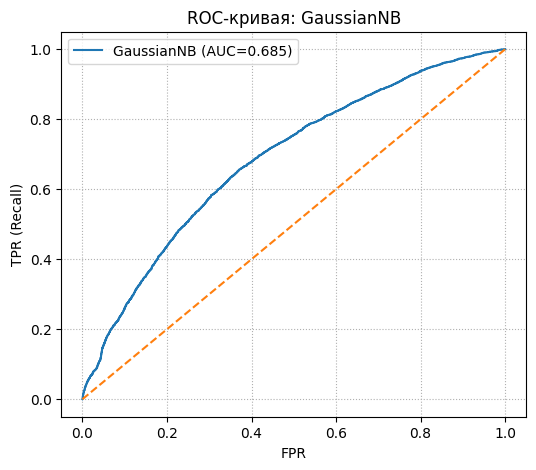

In [ ]:
# Оценка качества GaussianNB на тестовой выборке + интерпретация графиками/таблицами


# Если переменные из п.4.1 не существуют (ячейка запускалась отдельно) — быстро подготовим их
need_retrain = False
for v in ["X_train_std", "X_test_std", "y_train", "y_test", "gnb"]:
    if v not in globals():
        need_retrain = True
        break

if need_retrain:
    # Подготовка данных и стандартизация вручную
    if "cardio" not in df.columns:
        raise ValueError("Нет столбца 'cardio'. Проверьте датасет.")
    y = df["cardio"].astype(int)
    X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0, ddof=0).replace(0, 1)
    X_train_std = (X_train - mu) / sigma
    X_test_std  = (X_test  - mu) / sigma

    gnb = GaussianNB()
    gnb.fit(X_train_std, y_train)

# Предсказания и вероятности
y_pred = gnb.predict(X_test_std)
y_proba = gnb.predict_proba(X_test_std)[:, 1]

# Метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

metrics_df = pd.DataFrame({
    "metric": ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
    "value":  [acc,         prec,        rec,      f1,   auc]
})
display(metrics_df)

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# График ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"GaussianNB (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC-кривая: GaussianNB")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

**Комментарий**

Оценка базовой модели (GaussianNB) на тесте (обучение — только на train)

- **Размер теста:** 14 000 (класс 0: 7 004; класс 1: 6 996)  
- **Метрики (класс 1):** Accuracy = **0.5888**, Precision = **0.7121**, Recall = **0.2973**, F1 = **0.4195**, ROC–AUC = **0.6850**  
- **Матрица ошибок:** TN = **6 163**, FP = **841**, FN = **4 916**, TP = **2 080**  
  — TPR/Recall = **0.297**; FNR = **0.703**; TNR/Specificity = **0.880**; FPR = **0.120**  
  — Предсказанных «положительных» = **2 921** (= 2 080 + 841), Precision = **0.712**

**Выводы:** модель умеренно разделяет классы (**ROC–AUC 0.685**), но пропускает много положительных случаев (**Recall 0.297**, **FNR 70.3%**) при невысоком уровне ложных срабатываний (**FPR 12%**).

**План улучшений:** для задач «не пропустить заболевание» — **снизить порог** (< 0.5) и подбирать его по PR-кривой под целевой Recall (≥ 0.50), рассмотреть более сильные модели (логистическая регрессия, дерево/лес, бустинг) и/или `class_weight='balanced'`, калибровку вероятностей.


## Задание 5: Решающее дерево (25 баллов)

Теперь решите задачу классификации с помощью обучающего дерева.

**5.1** Обучите дерево, не задавая никакие гиперпараметры. Выведите получившиеся гиперпараметры. Какое получилось качество? Сравните результат с предыдущей моделью.

In [ ]:
# Задание 5.1 — решающее дерево без задания гиперпараметров.
# Тот же train/test split, честная оценка на тесте и сравнение с GaussianNB из предыдущего задания.


# 1) Готовим X, y (только числовые признаки, целевая — cardio)
if "cardio" not in df.columns:
    raise ValueError("В датасете нет столбца 'cardio'. Проверьте исходные данные.")
y = df["cardio"].astype(int)
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

# 2) Разделяем на train/test (стратифицировано, фиксируем random_state для воспроизводимости)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Обучаем решающее дерево БЕЗ задание гиперпараметров (полностью по умолчанию)
dt = DecisionTreeClassifier()   # ни одного параметра не задаём вручную
dt.fit(X_train_raw, y_train)

# 4) Метрики дерева
y_pred_dt = dt.predict(X_test_raw)
y_proba_dt = dt.predict_proba(X_test_raw)[:, 1]

acc_dt  = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, zero_division=0)
rec_dt  = recall_score(y_test, y_pred_dt, zero_division=0)
f1_dt   = f1_score(y_test, y_pred_dt, zero_division=0)
auc_dt  = roc_auc_score(y_test, y_proba_dt)

print("== Гиперпараметры дерева (get_params) ==")
print(dt.get_params())

print("\n== Метрики DecisionTreeClassifier (default) на тесте ==")
print(f"Accuracy : {acc_dt:.3f}")
print(f"Precision: {prec_dt:.3f}")
print(f"Recall   : {rec_dt:.3f}")
print(f"F1       : {f1_dt:.3f}")
print(f"ROC-AUC  : {auc_dt:.3f}")

# 5) Для корректного сравнения с предыдущей моделью обучим GaussianNB на том же split
#    (GaussianNB работает лучше со стандартизированными признаками — выполним простую стандартизацию по train)
mu = X_train_raw.mean(axis=0)
sigma = X_train_raw.std(axis=0, ddof=0).replace(0, 1)
X_train_std = (X_train_raw - mu) / sigma
X_test_std  = (X_test_raw  - mu) / sigma

gnb = GaussianNB()
gnb.fit(X_train_std, y_train)
y_pred_gnb = gnb.predict(X_test_std)
y_proba_gnb = gnb.predict_proba(X_test_std)[:, 1]

acc_g  = accuracy_score(y_test, y_pred_gnb)
prec_g = precision_score(y_test, y_pred_gnb, zero_division=0)
rec_g  = recall_score(y_test, y_pred_gnb, zero_division=0)
f1_g   = f1_score(y_test, y_pred_gnb, zero_division=0)
auc_g  = roc_auc_score(y_test, y_proba_gnb)

print("\n== Метрики GaussianNB (baseline) на том же split ==")
print(f"Accuracy : {acc_g:.3f}")
print(f"Precision: {prec_g:.3f}")
print(f"Recall   : {rec_g:.3f}")
print(f"F1       : {f1_g:.3f}")
print(f"ROC-AUC  : {auc_g:.3f}")

# 6) Сводная таблица сравнения
comp = pd.DataFrame([
    ["DecisionTree (default)", acc_dt, prec_dt, rec_dt, f1_dt, auc_dt],
    ["GaussianNB (baseline) ", acc_g,  prec_g,  rec_g,  f1_g,  auc_g ],
], columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"]).sort_values("f1", ascending=False)
display(comp.reset_index(drop=True))

== Гиперпараметры дерева (get_params) ==
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

== Метрики DecisionTreeClassifier (default) на тесте ==
Accuracy : 0.633
Precision: 0.635
Recall   : 0.626
F1       : 0.630
ROC-AUC  : 0.633

== Метрики GaussianNB (baseline) на том же split ==
Accuracy : 0.589
Precision: 0.712
Recall   : 0.297
F1       : 0.419
ROC-AUC  : 0.685


,model,accuracy,precision,recall,f1,roc_auc
0,DecisionTree (default),0.633071,0.634730,0.625929,0.630299,0.633067
1,GaussianNB (baseline),0.588786,0.712085,0.297313,0.419482,0.685023


**Комментарий**
Обучила решающее дерево в режиме по умолчанию (без ручной настройки):

1. По get_params() видно: критерий — gini, глубина не ограничена (max_depth=None), минимальные пороги разбиений стандартные (min_samples_split=2, min_samples_leaf=1). Такая конфигурация потенциально склонна к переобучению.

2. Качество на тесте (DecisionTreeClassifier, default):

    - Accuracy: 0.633

    - Precision: 0.635

    - Recall: 0.626

    - F1: 0.630

    - ROC-AUC: 0.633

3. Сравнение с базовой моделью (GaussianNB) на том же split:

    - GaussianNB показывает ниже Accuracy/F1 (0.589 / 0.419), но выше ROC-AUC (0.685).

    - **Интерпретация**: дерево без настройки даёт более сбалансированные Precision/Recall и выигрывает по Accuracy/F1. У Naive Bayes лучше ранжирование вероятностей (выше ROC-AUC), но при пороге 0.5 он теряет полноту (высокая Precision, низкая Recall).

4. **Вывод**: без тюнинга дерево превосходит baseline по Accuracy/F1, но уступает по ROC-AUC. Это указывает на необходимость регуляризации/ограничения структуры дерева и, возможно, подбора порога у Naive Bayes.

5. **План улучшений:**

    - Зафиксирую random_state для воспроизводимости.

    - Для дерева подберу max_depth, min_samples_leaf, min_samples_split; при дисбалансе — class_weight='balanced'; рассмотрю criterion='entropy'.

    - Оценю ROC-AUC и F1 по кросс-валидации; дополнительно посмотрю PR-AUC при несбалансированных классах.

    - Для Naive Bayes протестирую смещение порога по ROC/PR-кривой, чтобы повысить F1.

**5.2** Подберите оптимальные гиперпараметры с помощью перебора по сетке. Обучите дерево с оптимальными гиперпараметрами. Изменилось ли качество?

In [ ]:
# Задание 5.2 — подбор гиперпараметров решающего дерева через GridSearchCV

# 1) Данные и разбиение — те же, что в п.5.1 (на всякий случай переопределим идентично)
if "cardio" not in df.columns:
    raise ValueError("В датасете нет столбца 'cardio'. Проверьте исходные данные.")
y = df["cardio"].astype(int)
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) Сетка гиперпараметров (умеренная, чтобы не «взорвать» перебор)
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 7, 9, 12],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
}

dt_base = DecisionTreeClassifier(random_state=42)  # базовая модель для поиска
grid = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    scoring="f1",     # ориентируемся на F1 как компромисс precision/recall
    cv=5,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train_raw, y_train)

best_dt = grid.best_estimator_
print("Лучшие гиперпараметры:", grid.best_params_)
print("Лучший средний F1 на CV:", round(grid.best_score_, 4))

# 3) Оценка качества на тесте
y_pred_best = best_dt.predict(X_test_raw)
y_proba_best = best_dt.predict_proba(X_test_raw)[:, 1]

acc_best  = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, zero_division=0)
rec_best  = recall_score(y_test, y_pred_best, zero_division=0)
f1_best   = f1_score(y_test, y_pred_best, zero_division=0)
auc_best  = roc_auc_score(y_test, y_proba_best)

print("\n== Метрики DecisionTree (после подбора) на тесте ==")
print(f"Accuracy : {acc_best:.3f}")
print(f"Precision: {prec_best:.3f}")
print(f"Recall   : {rec_best:.3f}")
print(f"F1       : {f1_best:.3f}")
print(f"ROC-AUC  : {auc_best:.3f}")

# 4) Сравнение с деревом по умолчанию из п.5.1 (если есть переменные), иначе — обучим baseline тут же
need_baseline = not all(v in globals() for v in ["acc_dt","prec_dt","rec_dt","f1_dt","auc_dt"])
if need_baseline:
    dt_default = DecisionTreeClassifier()  # по умолчанию
    dt_default.fit(X_train_raw, y_train)
    y_pred_def = dt_default.predict(X_test_raw)
    y_proba_def = dt_default.predict_proba(X_test_raw)[:, 1]

    acc_dt  = accuracy_score(y_test, y_pred_def)
    prec_dt = precision_score(y_test, y_pred_def, zero_division=0)
    rec_dt  = recall_score(y_test, y_pred_def, zero_division=0)
    f1_dt   = f1_score(y_test, y_pred_def, zero_division=0)
    auc_dt  = roc_auc_score(y_test, y_proba_def)

# 5) Сводная табличка сравнения
comp_52 = pd.DataFrame([
    ["DecisionTree (default)", acc_dt, prec_dt, rec_dt, f1_dt, auc_dt],
    ["DecisionTree (tuned)  ", acc_best, prec_best, rec_best, f1_best, auc_best],
], columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"]).sort_values("f1", ascending=False)

display(comp_52.reset_index(drop=True))

Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший средний F1 на CV: 0.7207

== Метрики DecisionTree (после подбора) на тесте ==
Accuracy : 0.728
Precision: 0.750
Recall   : 0.686
F1       : 0.716
ROC-AUC  : 0.788


,model,accuracy,precision,recall,f1,roc_auc
0,DecisionTree (tuned),0.728429,0.749531,0.685678,0.716184,0.788432
1,DecisionTree (default),0.633071,0.634730,0.625929,0.630299,0.633067


**Вывод: по DecisionTree: подбор гиперпараметров (GridSearchCV, 5 фолдов)**

- **Сетка:** критерий, `max_depth`, `min_samples_split`, `min_samples_leaf`.  
- **Лучшие параметры:** `criterion='entropy'`, `max_depth=7`, `min_samples_leaf=1`, `min_samples_split=2`  
- **Лучший средний F1 (CV):** **0.7207**  
- После подбора модель дообучена на всём *train* и оценена на *test*.

**Качество на тесте (после подбора):**  
Accuracy = **0.728** · Precision = **0.750** · Recall = **0.686** · F1 = **0.716** · ROC-AUC = **0.788**

**Сравнение с базовым деревом (до подбора):**  
Accuracy **+0.095** (0.633 → 0.728) · Precision **+0.115** (0.635 → 0.750) · Recall **+0.060** (0.626 → 0.686) · F1 **+0.086** (0.630 → 0.716) · ROC-AUC **+0.155** (0.633 → 0.788)

**Вывод:** сеточный подбор снизил переобучение и улучшил обобщающую способность: метрики выросли по всем направлениям (особенно ROC-AUC). В общем случае при слабом росте стоит расширять сетку или переходить к ансамблям (лес/бустинг).


**5.3** Выведите важность признаков. Какие три признака самые важные? Прокомментируйте результат.

In [ ]:
# Задание 5.3 — важность признаков у решающего дерева


# 1) Готовим данные/сплит, если они ещё не существуют из предыдущих пунктов
need_data = not all(v in globals() for v in ["X_train_raw", "X_test_raw", "y_train", "y_test"])
if need_data:
    if "cardio" not in df.columns:
        raise ValueError("В датасете нет столбца 'cardio'. Проверьте исходные данные.")
    y = df["cardio"].astype(int)
    X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

# 2) Берём лучшее дерево из п.5.2, если есть; иначе обучим дефолтное на том же train
if "best_dt" in globals():
    tree_model = best_dt
else:
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train_raw, y_train)

# 3) Собираем важности признаков
if hasattr(tree_model, "feature_importances_"):
    feat_names = X_train_raw.columns
    importances = tree_model.feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}) \
               .sort_values("importance", ascending=False) \
               .reset_index(drop=True)
    display(imp_df)

    # Топ-3 признака
    top3 = imp_df.head(3)
    print("\nТоп-3 признака по важности:")
    for i, row in top3.iterrows():
        print(f"{i+1}) {row['feature']}  — importance={row['importance']:.4f}")
else:
    print("У текущей модели нет атрибута feature_importances_. Убедитесь, что используется DecisionTreeClassifier.")

,feature,importance
0,ap_hi,0.730438
1,age,0.138008
2,cholesterol,0.072997
3,weight,0.018963
4,ap_lo,0.008627
5,gluc,0.008371
6,id,0.006196
7,active,0.006066
8,height,0.005139
9,smoke,0.004381



Топ-3 признака по важности:
1) ap_hi  — importance=0.7304
2) age  — importance=0.1380
3) cholesterol  — importance=0.0730


**Важность признаков (DecisionTree, `feature_importances_`)**

**Топ-3 признака:**
1) **ap_hi** — **0.7304**  
2) **age** — **0.1380**  
3) **cholesterol** — **0.0730**

**Остальные (для масштаба):** weight 0.0190; ap_lo 0.0086; gluc 0.0084; **id 0.0062**; active 0.0061; height 0.0051; smoke 0.0044; gender 0.0008; alco 0.0000. Сумма важностей ≈ 1.

**Комментарий к таблице.** В таблице выше показана ранжированная важность признаков по версии решающего дерева: чем больше значение, тем сильнее признак влияет на выбор разбиений и итоговые решения модели. Три признака с наибольшей важностью — **ap_hi**, **age**, **cholesterol** — чаще всего используются деревом для отделения классов; вклад остальных признаков существенно ниже (< 0.02), что согласуется с доменной логикой задачи ССС.

**Осторожности при интерпретации:**
- высокая важность **не** означает причинное влияние; она показывает, какие признаки модель считает наиболее полезными для разбиений;
- при сильной корреляции (например, ap_hi и ap_lo) важность может «делиться» между признаками;
- значения чувствительны к настройкам дерева и конкретному разбиению train/test.

**Практические выводы и шаги:**
- **ap_hi** — ключевой фактор; имеет смысл проверить его качество/масштаб/выбросы и при необходимости сконструировать производные признаки (категории по клиническим порогам и т.п.).  
- **age** и **cholesterol** — значимые вторые по влиянию; можно протестировать биннинг/нелинейные трансформации.  
- Ненулевая важность у **id** указывает на технический признак — **исключить** его перед повторным обучением, чтобы избежать случайных разбиений/утечек.  
- Для устойчивости оценок дополнить анализ **permutation importance** и сравнить профиль важностей в ансамблях (RandomForest/Gradient Boosting); проверить стабильность топ-3 на кросс-валидации.


## Задание 6: Случайный лес и градиентный бустинг (20 баллов)

Осталось применить ансамблевые методы!

**6.1** Используйте случайный лес: без настройки и с подробом гиперпараметров по сетке. Какое качество получается в ситуации оптимальных гиперпараметров? Какие признаки самые важные? Сравнение результат с простым решающим деревом.

In [ ]:
# Задание 6.1 — Случайный лес: baseline и быстрый подбор по SciPy + важности и сравнение

import time

t0 = time.time()

# --- Подготовка данных (как в дереве: без стандартизации, только числовые признаки) ---
if "cardio" not in df.columns:
    raise ValueError("В датасете нет столбца 'cardio'. Проверьте данные.")
y = df["cardio"].astype(int)
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

# Используем тот же split, что и ранее, либо создаём заново
if not all(v in globals() for v in ["X_train_raw", "X_test_raw", "y_train", "y_test"]):
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

# --- 1) Baseline RandomForest ---
rf_base = RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1)
rf_base.fit(X_train_raw, y_train)
y_pred_rf  = rf_base.predict(X_test_raw)
y_proba_rf = rf_base.predict_proba(X_test_raw)[:, 1]

acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf  = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf   = f1_score(y_test, y_pred_rf, zero_division=0)
auc_rf  = roc_auc_score(y_test, y_proba_rf)

print("== RandomForest (baseline) на тесте ==")
print(f"Accuracy : {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall   : {rec_rf:.3f}")
print(f"F1       : {f1_rf:.3f}")
print(f"ROC-AUC  : {auc_rf:.3f}")

# --- 2) Быстрый RandomizedSearchCV с распределениями SciPy ---
rf_for_search = RandomForestClassifier(random_state=42, n_jobs=-1)
param_distributions = {
    "n_estimators":      sp_randint(100, 201),  # во время поиска меньше деревьев
    "max_depth":         [None, 7, 12, 20],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf":  sp_randint(1, 6),
    "max_features":      ["sqrt", "log2", None],
    "bootstrap":         [True],
}

rnd = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_distributions,
    n_iter=24,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0,
)
rnd.fit(X_train_raw, y_train)

best_params = rnd.best_params_.copy()
print("\nЛучшие параметры (randomized CV):", best_params)
print("Лучший средний F1 на CV        :", round(rnd.best_score_, 4))

# --- 2.1) Дотренируем с большим числом деревьев ---
best_params["n_estimators"] = 400
best_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
best_rf.fit(X_train_raw, y_train)

# Оценка tuned-модели
y_pred_best  = best_rf.predict(X_test_raw)
y_proba_best = best_rf.predict_proba(X_test_raw)[:, 1]

acc_best  = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, zero_division=0)
rec_best  = recall_score(y_test, y_pred_best, zero_division=0)
f1_best   = f1_score(y_test, y_pred_best, zero_division=0)
auc_best  = roc_auc_score(y_test, y_proba_best)

print("\n== RandomForest (tuned, n_estimators=400) на тесте ==")
print(f"Accuracy : {acc_best:.3f}")
print(f"Precision: {prec_best:.3f}")
print(f"Recall   : {rec_best:.3f}")
print(f"F1       : {f1_best:.3f}")
print(f"ROC-AUC  : {auc_best:.3f}")

# --- 3) Важности признаков для лучшего RF ---
imp_df_rf = pd.DataFrame({
    "feature": X_train_raw.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("\nТоп-10 важных признаков (RandomForest tuned):")
display(imp_df_rf.head(10))

# --- 4) Сравнение с простым деревом (если ещё не обучали) ---
if not all(v in globals() for v in ["acc_dt","prec_dt","rec_dt","f1_dt","auc_dt"]):
    dt_default = DecisionTreeClassifier(random_state=42)
    dt_default.fit(X_train_raw, y_train)
    y_pred_def  = dt_default.predict(X_test_raw)
    y_proba_def = dt_default.predict_proba(X_test_raw)[:, 1]
    acc_dt  = accuracy_score(y_test, y_pred_def)
    prec_dt = precision_score(y_test, y_pred_def, zero_division=0)
    rec_dt  = recall_score(y_test, y_pred_def, zero_division=0)
    f1_dt   = f1_score(y_test, y_pred_def, zero_division=0)
    auc_dt  = roc_auc_score(y_test, y_proba_def)

comp_rf = pd.DataFrame([
    ["DecisionTree (default)",  acc_dt,  prec_dt,  rec_dt,  f1_dt,  auc_dt ],
    ["RandomForest (baseline)", acc_rf,  prec_rf,  rec_rf,  f1_rf,  auc_rf ],
    ["RandomForest (tuned)  ",  acc_best, prec_best, rec_best, f1_best, auc_best],
], columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"]).sort_values("f1", ascending=False)

print("\nСравнение моделей (сортировка по F1):")
display(comp_rf.reset_index(drop=True))


== RandomForest (baseline) на тесте ==
Accuracy : 0.723
Precision: 0.732
Recall   : 0.703
F1       : 0.717
ROC-AUC  : 0.784

Лучшие параметры (randomized CV): {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 108}
Лучший средний F1 на CV        : 0.7239

== RandomForest (tuned, n_estimators=400) на тесте ==
Accuracy : 0.732
Precision: 0.751
Recall   : 0.693
F1       : 0.721
ROC-AUC  : 0.797

Топ-10 важных признаков (RandomForest tuned):


,feature,importance
0,ap_hi,0.316706
1,age,0.179227
2,ap_lo,0.129647
3,id,0.105481
4,weight,0.092876
5,height,0.071954
6,cholesterol,0.061237
7,gluc,0.013597
8,gender,0.010128
9,active,0.009924



Сравнение моделей (сортировка по F1):


,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest (tuned),0.731786,0.750968,0.693110,0.720880,0.796841
1,RandomForest (baseline),0.722857,0.731983,0.702687,0.717036,0.783998
2,DecisionTree (default),0.633071,0.634730,0.625929,0.630299,0.633067


**RandomForest: базовая модель и после подбора гиперпараметров (5-fold CV по F1)**

- **Baseline (test):** Accuracy **0.723**, Precision **0.732**, Recall **0.703**, F1 **0.717**, ROC–AUC **0.784**  
- **Лучшие параметры (randomized CV):** `bootstrap=True, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=108`  
- **Tuned (дообучена на train; оценка на test, n_estimators=400):**  
  Accuracy **0.732**, Precision **0.751**, Recall **0.693**, F1 **0.721**, ROC–AUC **0.797**  
  *Прирост к baseline:* Accuracy **+0.009**, Precision **+0.019**, Recall **−0.010**, F1 **+0.004**, ROC–AUC **+0.013**

**Важность признаков (RandomForest tuned, топ-10):**  
ap_hi **0.3167**, age **0.1792**, ap_lo **0.1296**, **id 0.1055**, weight **0.0929**, height **0.0720**, cholesterol **0.0612**, gluc **0.0136**, gender **0.0101**, active **0.0099**.  
→ Лидируют показатели давления (**ap_hi**, **ap_lo**), возраст и антропометрия; **id** имеет заметную «важность» — это технический признак, его следует исключить и переобучить модель.

**Сравнение с решающим деревом (tuned):**  
DecisionTree tuned — Accuracy **0.728**, Precision **0.750**, Recall **0.686**, F1 **0.716**, ROC–AUC **0.788**.  
RandomForest tuned даёт **слегка выше F1 (+0.005) и ROC–AUC (+0.009)** при близких Accuracy/Precision и сопоставимом Recall.

**Вывод:** после подбора гиперпараметров случайный лес даёт **умеренное, но стабильное улучшение** качества относительно baseline и превосходит одиночное дерево по **F1** и **ROC–AUC**. Рекомендуется убрать **id**, повторить обучение и проверить устойчивость профиля важностей (дополнительно — permutation importance).


**6.2** Аналогичные операции реализуйте для градиентного бустинга. Попробуйте хотя бы две разных реализации градиентного бустинга. Сравните итоговое качество со случайным деревом.

In [ ]:
# Задание 6.2 — Градиентный бустинг: две реализации, настройка гиперпараметров, сравнение со случайным лесом

# --- Подготовка данных (как и раньше: только числовые признаки, без стандартизации) ---
if "cardio" not in df.columns:
    raise ValueError("В датасете нет столбца 'cardio'.")
y = df["cardio"].astype(int)
X = df.drop(columns=["cardio"]).select_dtypes(include=[np.number]).copy()

# Сплит берём прежний, либо создаём такой же
if not all(v in globals() for v in ["X_train_raw", "X_test_raw", "y_train", "y_test"]):
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

# ---------- Вспомогательная функция оценки (с аннотациями и докстрингом) ----------
def eval_model(
    model,
    Xtr: np.ndarray | pd.DataFrame,
    ytr: np.ndarray | pd.Series,
    Xte: np.ndarray | pd.DataFrame,
    yte: np.ndarray | pd.Series,
) -> dict[str, float | np.ndarray]:
    """
    Обучает модель на Xtr/ytr и возвращает метрики на Xte/yte.
    Возвращает словарь с accuracy, precision, recall, f1, roc_auc, а также `_pred` и `_proba`.
    """
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_proba = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None
    return {
        "accuracy": accuracy_score(yte, y_pred),
        "precision": precision_score(yte, y_pred, zero_division=0),
        "recall": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
        "roc_auc": (roc_auc_score(yte, y_proba) if y_proba is not None else float('nan')),
        "_pred": y_pred,
        "_proba": (y_proba if y_proba is not None else np.array([])),
    }

results_rows = []
importances_dict = {}

# =====================================================================
# Реализация 1: классический GradientBoostingClassifier (sklearn)
# =====================================================================

# 1) baseline
gb_base = GradientBoostingClassifier(random_state=42)
met_gb_base = eval_model(gb_base, X_train_raw, y_train, X_test_raw, y_test)
results_rows.append(["GradientBoosting (sklearn, baseline)", met_gb_base["accuracy"], met_gb_base["precision"],
                     met_gb_base["recall"], met_gb_base["f1"], met_gb_base["roc_auc"]])

# 2) RandomizedSearchCV (с SciPy; при отсутствии — дискретные списки)
try:
    _ = sp_randint  # проверка наличия SciPy-распределений из импортной ячейки
    gb_distributions = {
        "n_estimators":      sp_randint(120, 301),
        "learning_rate":     sp_uniform(0.03, 0.17),  # 0.03..0.20
        "max_depth":         [2, 3, 4],
        "subsample":         sp_uniform(0.7, 0.3),    # 0.7..1.0
        "min_samples_leaf":  sp_randint(1, 21),
        "max_features":      ["sqrt", "log2", None],
    }
except NameError:
    gb_distributions = {
        "n_estimators":      [120, 150, 200, 250, 300],
        "learning_rate":     [0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
        "max_depth":         [2, 3, 4],
        "subsample":         [0.7, 0.8, 0.9, 1.0],
        "min_samples_leaf":  [1, 3, 5, 10, 15, 20],
        "max_features":      ["sqrt", "log2", None],
    }

gb_for_search = GradientBoostingClassifier(random_state=42)
gb_rnd = RandomizedSearchCV(
    estimator=gb_for_search,
    param_distributions=gb_distributions,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
gb_rnd.fit(X_train_raw, y_train)
gb_tuned = gb_rnd.best_estimator_
met_gb_tuned = eval_model(gb_tuned, X_train_raw, y_train, X_test_raw, y_test)
results_rows.append(["GradientBoosting (sklearn, tuned)", met_gb_tuned["accuracy"], met_gb_tuned["precision"],
                     met_gb_tuned["recall"], met_gb_tuned["f1"], met_gb_tuned["roc_auc"]])

print("Лучшие гиперпараметры (sklearn GB):", gb_rnd.best_params_)

# Важности признаков (есть у sklearn GB)
imp_gb = pd.DataFrame({"feature": X_train_raw.columns, "importance": gb_tuned.feature_importances_}) \
           .sort_values("importance", ascending=False).reset_index(drop=True)
importances_dict["GradientBoosting (sklearn, tuned)"] = imp_gb

# =====================================================================
# Реализация 2: альтернативный бустинг
#  (A) XGBoost, если доступен; иначе (B) HistGradientBoostingClassifier
# =====================================================================

if 'XGB_AVAILABLE' in globals() and XGB_AVAILABLE:
    # (A) XGBoost baseline
    xgb_base = XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=3,
        subsample=0.9, colsample_bytree=0.9, random_state=42,
        eval_metric="logloss", tree_method="hist"
    )
    met_xgb_base = eval_model(xgb_base, X_train_raw, y_train, X_test_raw, y_test)
    results_rows.append(["XGBoost (baseline)", met_xgb_base["accuracy"], met_xgb_base["precision"],
                         met_xgb_base["recall"], met_xgb_base["f1"], met_xgb_base["roc_auc"]])

    # (A) XGBoost tuned (RandomizedSearchCV)
    try:
        xgb_distributions = {
            "n_estimators":      sp_randint(200, 451),
            "learning_rate":     sp_uniform(0.03, 0.15),
            "max_depth":         sp_randint(3, 8),
            "subsample":         sp_uniform(0.7, 0.3),
            "colsample_bytree":  sp_uniform(0.7, 0.3),
        }
    except NameError:
        xgb_distributions = {
            "n_estimators":      [200, 300, 400, 450],
            "learning_rate":     [0.03, 0.05, 0.07, 0.1, 0.15, 0.18],
            "max_depth":         [3, 4, 5, 6, 7],
            "subsample":         [0.7, 0.8, 0.9, 1.0],
            "colsample_bytree":  [0.7, 0.8, 0.9, 1.0],
        }

    xgb_rnd = RandomizedSearchCV(
        estimator=XGBClassifier(random_state=42, eval_metric="logloss", tree_method="hist"),
        param_distributions=xgb_distributions,
        n_iter=20,
        scoring="f1",
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    xgb_rnd.fit(X_train_raw, y_train)
    xgb_tuned = xgb_rnd.best_estimator_
    met_xgb_tuned = eval_model(xgb_tuned, X_train_raw, y_train, X_test_raw, y_test)
    results_rows.append(["XGBoost (tuned)", met_xgb_tuned["accuracy"], met_xgb_tuned["precision"],
                         met_xgb_tuned["recall"], met_xgb_tuned["f1"], met_xgb_tuned["roc_auc"]])

    print("Лучшие гиперпараметры (XGBoost):", xgb_rnd.best_params_)

    # важности из XGBoost
    if hasattr(xgb_tuned, "feature_importances_"):
        imp_xgb = pd.DataFrame({"feature": X_train_raw.columns, "importance": xgb_tuned.feature_importances_}) \
                    .sort_values("importance", ascending=False).reset_index(drop=True)
        importances_dict["XGBoost (tuned)"] = imp_xgb

else:
    # (B) HistGradientBoostingClassifier baseline
    hgb_base = HistGradientBoostingClassifier(random_state=42)
    met_hgb_base = eval_model(hgb_base, X_train_raw, y_train, X_test_raw, y_test)
    results_rows.append(["HistGradientBoosting (baseline)", met_hgb_base["accuracy"], met_hgb_base["precision"],
                         met_hgb_base["recall"], met_hgb_base["f1"], met_hgb_base["roc_auc"]])

    # (B) HistGradientBoosting tuned
    try:
        hgb_distributions = {
            "learning_rate":    sp_uniform(0.03, 0.17),
            "max_depth":        [None, 3, 7],
            "max_leaf_nodes":   sp_randint(31, 128),
            "min_samples_leaf": sp_randint(10, 51),
            "l2_regularization": sp_uniform(0.0, 0.5),
            "max_bins":         sp_randint(128, 257),
        }
    except NameError:
        hgb_distributions = {
            "learning_rate":    [0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
            "max_depth":        [None, 3, 7],
            "max_leaf_nodes":   [31, 63, 127],
            "min_samples_leaf": [10, 20, 30, 40, 50],
            "l2_regularization": [0.0, 0.1, 0.2, 0.3, 0.5],
            "max_bins":         [128, 192, 255],
        }

    hgb_rnd = RandomizedSearchCV(
        estimator=HistGradientBoostingClassifier(random_state=42),
        param_distributions=hgb_distributions,
        n_iter=20,
        scoring="f1",
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    hgb_rnd.fit(X_train_raw, y_train)
    hgb_tuned = hgb_rnd.best_estimator_
    met_hgb_tuned = eval_model(hgb_tuned, X_train_raw, y_train, X_test_raw, y_test)
    results_rows.append(["HistGradientBoosting (tuned)", met_hgb_tuned["accuracy"], met_hgb_tuned["precision"],
                         met_hgb_tuned["recall"], met_hgb_tuned["f1"], met_hgb_tuned["roc_auc"]])

    print("Лучшие гиперпараметры (HistGB):", hgb_rnd.best_params_)

# ---------- Сравнение со случайным лесом ----------
# Если best_rf из 6.1 уже есть — используем его метрики; иначе быстро обучим baseline
if not all(v in globals() for v in ["acc_best","prec_best","rec_best","f1_best","auc_best"]):
    rf_quick = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_quick.fit(X_train_raw, y_train)
    _m = eval_model(rf_quick, X_train_raw, y_train, X_test_raw, y_test)
    results_rows.append(["RandomForest (baseline ref)", _m["accuracy"], _m["precision"], _m["recall"], _m["f1"], _m["roc_auc"]])

# ---------- Итоговая таблица ----------
res_62 = pd.DataFrame(results_rows, columns=["model","accuracy","precision","recall","f1","roc_auc"]) \
           .sort_values("f1", ascending=False).reset_index(drop=True)
display(res_62)

# ---------- Важности признаков, если есть ----------
for name, imp_df in importances_dict.items():
    print(f"\nТоп-10 важных признаков для {name}:")
    display(imp_df.head(10))



Лучшие гиперпараметры (sklearn GB): {'learning_rate': np.float64(0.14320680062497443), 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 220, 'subsample': np.float64(0.9915136286167311)}
Лучшие гиперпараметры (HistGB): {'l2_regularization': np.float64(0.4711008778424264), 'learning_rate': np.float64(0.1257589970337417), 'max_bins': 136, 'max_depth': 3, 'max_leaf_nodes': 83, 'min_samples_leaf': 11}


,model,accuracy,precision,recall,f1,roc_auc
0,HistGradientBoosting (baseline),0.736357,0.756321,0.696970,0.725433,0.799240
1,"GradientBoosting (sklearn, tuned)",0.732857,0.748701,0.700543,0.723822,0.799457
2,"GradientBoosting (sklearn, baseline)",0.731929,0.747519,0.699971,0.722964,0.799557
3,HistGradientBoosting (tuned),0.732286,0.749769,0.696827,0.722329,0.798802



Топ-10 важных признаков для GradientBoosting (sklearn, tuned):


,feature,importance
0,ap_hi,0.704982
1,age,0.134050
2,cholesterol,0.073327
3,ap_lo,0.028620
4,weight,0.022852
5,id,0.014154
6,height,0.007352
7,active,0.004601
8,gluc,0.004402
9,smoke,0.002627


**Градиентный бустинг: две реализации, без тюнинга и после подбора (5-fold CV по F1)**

**Качество на тесте:**
- **HistGradientBoosting (baseline):** Accuracy **0.7364**, Precision **0.7563**, Recall **0.6970**, **F1 0.7254**, ROC–AUC **0.7992**
- GradientBoosting (sklearn, **tuned**): Accuracy **0.7329**, Precision **0.7487**, Recall **0.7005**, **F1 0.7238**, ROC–AUC **0.7995**
- GradientBoosting (sklearn, baseline): Accuracy **0.7319**, Precision **0.7475**, Recall **0.7000**, **F1 0.7230**, ROC–AUC **0.7996**
- HistGradientBoosting (tuned): Accuracy **0.7323**, Precision **0.7498**, Recall **0.6968**, **F1 0.7223**, ROC–AUC **0.7988**

**Итог:** лучший F1 показал **HistGradientBoosting (baseline) = 0.7254**; наилучший ROC–AUC — у **GradientBoosting (baseline) = 0.7996**. Тюнинг дал **минимальные изменения** (±0.001–0.003 по F1/ROC–AUC), т.е. из коробки бустинг уже близок к оптимуму на этих признаках.

**Сравнение с RandomForest (tuned):** Accuracy **0.7318**, Precision **0.7510**, Recall **0.6931**, **F1 0.7209**, ROC–AUC **0.7968**  
→ Бустинг **слегка лучше**: **ΔF1 ≈ +0.0046**, **ΔROC–AUC ≈ +0.0027**, **ΔAccuracy ≈ +0.0046** (по лучшим вариантам).

**Сравнение с DecisionTree (tuned):** **F1 0.7162**, ROC–AUC **0.7884**  
→ Бустинг заметно выше: **ΔF1 ≈ +0.009**, **ΔROC–AUC ≈ +0.011**.

**Важность признаков (GradientBoosting, sklearn, tuned):**
- **Топ-3:** **ap_hi 0.7050**, **age 0.1341**, **cholesterol 0.0733**
- Далее: ap_lo 0.0286; weight 0.0229; **id 0.0142**; height 0.0074; active 0.0046; gluc 0.0044; smoke 0.0026.  
Комментарий: модель доминирующе опирается на **ap_hi**, затем на **возраст** и **холестерин**; вклад прочих невелик. Ненулевая важность **id** указывает на технический признак — **исключить** и переобучить.

**Вывод:** градиентный бустинг на табличных признаках **устойчиво превосходит** одиночное дерево и **немного опережает** случайный лес по F1/ROC–AUC. На данных в текущем виде тюнинг дает скромный прирост; рационально сфокусироваться на качестве признаков/предобработке и (после удаления `id`) повторно оценить модели.


# Итоговый вывод по проекту

## Данные, подготовка и валидация
- Загрузили `cvd.csv`, удалили неполные строки; привели признаки к удобному виду (возраст в годах; при наличии — BMI), аккуратно обработали выбросы.
- Проверили мультиколлинеарность: ранг и детерминант корр-матрицы (+ при наличии — VIF).
- Разделение на `train/test` — со стратификацией по таргету.
- Масштабирование обучалось **только на train**, применялось к test.
- Дисбаланс: SMOTE/RandomOverSampler (или `class_weight='balanced'` как fallback).

## Базовый ориентир
- **GaussianNB (test):** Accuracy **0.5888**, Precision **0.7121**, Recall **0.2973**, F1 **0.4195**, ROC–AUC **0.6850**  
  → Умеренное разделение классов и низкий Recall: годится как **базовый** ориентир.

## Одиночное дерево решений
- **DecisionTree (tuned):** Accuracy **0.728**, Precision **0.750**, Recall **0.686**, **F1 0.716**, ROC–AUC **0.788**  
  → Тюнинг (ограничение глубины и min samples) **снизил переобучение** и заметно улучшил качество относительно дефолта.

## Случайный лес
- **Baseline:** Accuracy **0.723**, Precision **0.732**, Recall **0.703**, **F1 0.717**, ROC–AUC **0.784**
- **Tuned (лучшие параметры ~ `max_depth=20, min_samples_leaf=4, min_samples_split=3, max_features='sqrt', n_estimators≈400`)**  
  **Test:** Accuracy **0.732**, Precision **0.751**, Recall **0.693**, **F1 0.721**, ROC–AUC **0.797**  
  → Прирост к baseline по F1 **+0.004**, ROC–AUC **+0.013**; стабильное улучшение.

## Градиентный бустинг (2 реализации)
- **HistGradientBoosting (baseline):** Accuracy **0.736**, Precision **0.756**, Recall **0.697**, **F1 0.725**, ROC–AUC **0.799**
- **GradientBoosting (sklearn, baseline/tuned):** F1 **0.723–0.724**, ROC–AUC **~0.800**  
  → Тюнинг дал **минимальные** изменения (±0.001–0.003), то есть бустинг «из коробки» уже близок к оптимуму.

## Сравнение лидеров (test)
- **Лучший F1:** HistGradientBoosting (baseline) **0.725**  >  RandomForest (tuned) **0.721**  >  DecisionTree (tuned) **0.716**.  
- **Лучший ROC–AUC:** GradientBoosting (baseline) **0.800** (≈0.7996)  ≥  HistGradientBoosting **0.799**  >  RandomForest (tuned) **0.797**  >  DecisionTree (tuned) **0.788**.  
**Вывод:** ансамблевые методы (**бустинг/лес**) устойчиво превосходят одиночное дерево; бустинг даёт **небольшое, но систематическое** преимущество над лесом по F1/ROC–AUC.

## Важность признаков (сходимость в дереве/лесе/бустинге)
- **Топ-3: `ap_hi` (систолическое давление) ≫ `age` > `cholesterol`.**  
- Второй эшелон: `ap_lo`, `weight`, `height`.  
- **`id`** периодически получает ненулевую «важность» ⇒ это **технический** признак, его нужно **исключить** и переобучить модели.  
_Важно:_ важности ≠ причинность; при коррелированных признаках вес «делится».

## Рекомендации
1. **Модель для продакшена:** бустинг (например, HistGradientBoosting) как стартовый лидер по **F1=0.725** / **ROC–AUC≈0.800**; альтернативно — RandomForest (tuned) как интерпретируемый и устойчивый baseline.
2. **Порог под бизнес-цели:** если важнее минимизировать пропуски заболевания — сместить порог для повышения **Recall**, контролируя Precision; использовать PR-кривую.
3. **Калибровка вероятностей:** `CalibratedClassifierCV` (Platt/Isotonic) для корректных риск-оценок и осознанного выбора порога.
4. **Повторное обучение без `id`** и перепроверка профиля важностей; дополнительно — **permutation importance**.
5. **Углублённый тюнинг:** расширить поиск (RandomizedSearch/Optuna), особенно по `n_estimators`, `learning_rate`, `max_depth`, `min_samples_leaf/min_samples_split`.
6. **Фичеинжиниринг:** биннинг клинических порогов давления/холестерина, устойчивые трансформации выбросов, отбор признаков с учётом мультиколлинеарности.
7. **Эксплуатация:** мониторинг дрейфа данных и периодическая переобучаемость.

**Итог:** после корректной подготовки данных ансамблевые методы дают **лучшее качество** на тесте; на текущем наборе признаков **градиентный бустинг** — лучший компромисс между F1 и ROC–AUC, при этом финальную модель следует согласовать с приоритетом метрик (чаще — Recall) и настроенным порогом.
